In [47]:
# =============================================================================
# 数据读取和初始处理
# =============================================================================

from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 兼容 Jupyter 环境下没有 __file__ 的情况，自动寻找 raw/MBH_Experiment2.csv
candidate_paths = []
try:
    # 脚本环境
    base_dir = Path(__file__).parent.parent
    candidate_paths.append(base_dir / "raw" / "MBH_Experiment2.csv")
except NameError:
    # Jupyter 环境
    candidate_paths.append(Path.cwd().parent / "raw" / "MBH_Experiment2.csv")
    candidate_paths.append(Path.cwd() / "raw" / "MBH_Experiment2.csv")

csv_path = next((p for p in candidate_paths if p.exists()), candidate_paths[0])
if not csv_path.exists():
    raise FileNotFoundError(f"CSV not found. Tried: {candidate_paths}")

# 读取 CSV（带 BOM 时使用 utf-8-sig 更稳妥）
df_raw = pd.read_csv(csv_path, encoding="utf-8-sig")
print(f"第1步 - 数据读取完成: {csv_path} | 形状={df_raw.shape}")

第1步 - 数据读取完成: /Users/xingjianzhang/Library/CloudStorage/OneDrive-个人/obsdian/madebyhuman/code/raw/MBH_Experiment2.csv | 形状=(1202, 102)


In [48]:
# =============================================================================
# 第2步：删除不需要的抬头行
# =============================================================================

print(f"第2步 - 删除抬头行")
print(f"处理前数据量: {df_raw.shape[0]}")

# 检查并显示StartDate列的前几个值
print(f"StartDate列的前10个值: {df_raw['StartDate'].head(10).tolist()}")

# 删除两个不需要的抬头行
df_step2 = df_raw[
    (df_raw['StartDate'] != "Start Date") & 
    (df_raw['StartDate'] != '{"ImportId":"startDate","timeZone":"America/New_York"}')
].copy()

print(f"处理后数据量: {df_step2.shape[0]}")
print(f"删除了 {df_raw.shape[0] - df_step2.shape[0]} 行抬头数据")

# 重置索引
df_step2.reset_index(drop=True, inplace=True)

第2步 - 删除抬头行
处理前数据量: 1202
StartDate列的前10个值: ['Start Date', '{"ImportId":"startDate","timeZone":"America/New_York"}', '2025-09-30 17:30:16', '2025-09-30 17:34:15', '2025-09-30 17:32:50', '2025-09-30 17:30:41', '2025-09-30 17:34:31', '2025-09-30 17:35:26', '2025-09-30 17:35:03', '2025-09-30 17:36:54']
处理后数据量: 1200
删除了 2 行抬头数据


In [49]:
# =============================================================================
# 第3步：处理重复的Prolific ID
# =============================================================================

print(f"第3步 - 处理重复参与者")

# 找出重复的Prolific ID
duplicate_ids = df_step2[df_step2.duplicated(subset=['Prolific ID'], keep=False)]
print(f"发现重复的Prolific ID记录: {len(duplicate_ids)} 条")

if len(duplicate_ids) > 0:
    print("重复的Prolific ID详情:")
    print(duplicate_ids[['Prolific ID', 'StartDate', 'EndDate']])


第3步 - 处理重复参与者
发现重复的Prolific ID记录: 0 条


In [50]:
# =============================================================================
# 第4步：数据宽转长处理
# =============================================================================

print(f"第4步 - 数据宽转长处理")

# 识别所有实验变量
hr_vars = [col for col in df_step2.columns if col.startswith('HR_')]
med_vars = [col for col in df_step2.columns if col.startswith('Med_')]
experiment_vars = hr_vars + med_vars

print(f"找到实验变量 {len(experiment_vars)} 个:")
print(f"  HR变量: {len(hr_vars)} 个")
print(f"  Med变量: {len(med_vars)} 个")

# 检查每个变量的非缺失值数量
non_missing_counts = {var: df_step2[var].notna().sum() for var in experiment_vars}
print(f"各变量非缺失值范围: {min(non_missing_counts.values())} - {max(non_missing_counts.values())}")

# 执行宽转长操作
df_step4 = df_step2.melt(
    id_vars=[col for col in df_step2.columns if col not in experiment_vars],
    value_vars=experiment_vars,
    var_name='original_var',
    value_name='original_answer'
)

# 只保留非缺失的观测值
df_step4 = df_step4[df_step4['original_answer'].notna()].copy()
df_step4.reset_index(drop=True, inplace=True)

print(f"宽转长完成: {df_step2.shape} → {df_step4.shape}")

第4步 - 数据宽转长处理
找到实验变量 36 个:
  HR变量: 18 个
  Med变量: 18 个
各变量非缺失值范围: 10 - 79
宽转长完成: (1200, 102) → (1200, 68)


In [51]:
# =============================================================================
# 第5步：解析实验条件变量
# =============================================================================

print(f"第5步 - 解析实验条件")

# 按下划线拆分 original_var → 5列
split_cols = df_step4['original_var'].astype(str).str.split('_', n=4, expand=True)
split_cols.columns = ['report_type', 'source_type', 'information', 'analysis', 'recommendation']

# 合并到主数据框
df_step5 = pd.concat([df_step4, split_cols], axis=1)

print(f"解析完成，新增5个条件变量:")
print(f"  report_type: {df_step5['report_type'].unique()}")
print(f"  source_type: {df_step5['source_type'].unique()}")
print(f"  information: {df_step5['information'].unique()}")
print(f"  analysis: {df_step5['analysis'].unique()}")
print(f"  recommendation: {df_step5['recommendation'].unique()}")

第5步 - 解析实验条件
解析完成，新增5个条件变量:
  report_type: ['HR' 'Med']
  source_type: ['AI' 'Human']
  information: ['no' 'yes' 'none']
  analysis: ['no' 'yes' None]
  recommendation: ['no' 'yes' None 'ye']


In [52]:
# =============================================================================
# 第6步：创建分析变量
# =============================================================================

print(f"第6步 - 创建分析变量")

# 创建AI披露变量
df_step6 = df_step5.copy()
df_step6['AI_disclosure'] = (df_step6['information'] != 'none')

# 创建是否遵循推荐变量
df_step6['followed_recommendation'] = df_step6['original_answer'].isin([
    'Kinetic Workforce (KNTC)', 
    'Vista Therapeutics (VSTA)'
])

# 创建条件组合变量
df_step6['condition'] = df_step6['original_var'].str.split('_', n=2).str[2]

# 创建condition_broad变量
df_step6['condition_broad'] = df_step6['condition'].apply(
    lambda x: x if x in ['no_no_no', 'none', 'yes_yes_yes'] else 'mix'
)

print(f"创建的分析变量:")
print(f"  AI_disclosure: {df_step6['AI_disclosure'].value_counts()}")
print(f"  followed_recommendation: {df_step6['followed_recommendation'].value_counts()}")
print(f"  condition分布: {len(df_step6['condition'].unique())} 种不同条件")

第6步 - 创建分析变量
创建的分析变量:
  AI_disclosure: AI_disclosure
True     898
False    302
Name: count, dtype: int64
  followed_recommendation: followed_recommendation
False    603
True     597
Name: count, dtype: int64
  condition分布: 10 种不同条件


In [53]:
# =============================================================================
# 第7步：数据清理和标准化
# =============================================================================

print(f"第7步 - 数据清理和标准化")

df_clean = df_step6.copy()

before_fix = df_clean['recommendation'].value_counts()
df_clean['recommendation'] = df_clean['recommendation'].replace('ye', 'yes')
after_fix = df_clean['recommendation'].value_counts()
print(f"修正recommendation: ye → yes")

df_clean['information'] = df_clean['information'].replace('none', pd.NA)

df_clean['condition'] = df_clean['condition'].replace('yes_yes_ye', 'yes_yes_yes')

df_clean['original_var'] = df_clean['original_var'].astype(str).str.strip()

# 生成新的condition_broad，no_no_no, none, yes_yes_yes保持不变，其余归为partial
df_clean['condition_broad'] = df_clean['condition'].apply(
    lambda x: x if x in ['no_no_no', 'none', 'yes_yes_yes'] else 'partial'
)

# rename Q234_1 to process, Q234_2 to performance
df_clean.rename(columns={'Q234_1': 'process', 
                         'Q234_2': 'performance',
                         'Q232_1': 'truthful_disclosure',
                         'Q219_1': 'analyst_ability_1',
                         'Q219_2': 'analyst_ability_2',
                         'Q219_3': 'analyst_ability_3',
                         'Q220_1': 'analyst_benevolence_1',
                         'Q220_2': 'analyst_benevolence_2',
                         'Q220_3': 'analyst_benevolence_3',
                         'Q221_1': 'analyst_integrity_1',
                         'Q221_2': 'analyst_integrity_2',
                         'Q221_3': 'analyst_integrity_3',
                         'Q224_1': 'firm_ability_1',
                         'Q224_2': 'firm_ability_2',
                         'Q224_3': 'firm_ability_3',
                         'Q225_1': 'firm_benevolence_1',
                         'Q225_2': 'firm_benevolence_2',
                         'Q225_3': 'firm_benevolence_3',
                         'Q226_1': 'firm_integrity_1',
                         'Q226_2': 'firm_integrity_2',
                         'Q226_3': 'firm_integrity_3',
                         'Q19': 'year_of_birth',
                         'Q20': 'gender',
                         'Q21': 'race',
                         'Q22': 'occupation',
                         'Q23': 'income',
                         'Q227_1': 'ai_attitude_1',
                         'Q227_2': 'ai_attitude_2',
                         'Q227_3': 'ai_attitude_3',
                         'Q227_4': 'ai_attitude_4',
                         'Q227_5': 'ai_investment',
                         }, inplace=True)

# 将量表题的字符串转换为数值
def extract_scale_numeric(series: pd.Series) -> pd.Series:
    extracted = series.astype(str).str.extract(r'(\d+)')[0]
    return pd.to_numeric(extracted, errors='coerce').astype('Int64')

scale_columns = [
    'process', 'performance', 'truthful_disclosure',
    'analyst_ability_1', 'analyst_ability_2', 'analyst_ability_3',
    'analyst_benevolence_1', 'analyst_benevolence_2', 'analyst_benevolence_3',
    'analyst_integrity_1', 'analyst_integrity_2', 'analyst_integrity_3',
    'firm_ability_1', 'firm_ability_2', 'firm_ability_3',
    'firm_benevolence_1', 'firm_benevolence_2', 'firm_benevolence_3',
    'firm_integrity_1', 'firm_integrity_2', 'firm_integrity_3',
    'ai_attitude_1', 'ai_attitude_2', 'ai_attitude_3', 'ai_attitude_4',
    'ai_investment'
]

for col in scale_columns:
    df_clean[col] = extract_scale_numeric(df_clean[col])

# yob转化为整数
df_clean['year_of_birth'] = pd.to_numeric(df_clean['year_of_birth'], errors='coerce').astype('Int64')

# analyst_ability, benevolence, integrity三项取平均
df_clean['analyst_ability'] = df_clean[['analyst_ability_1', 'analyst_ability_2', 'analyst_ability_3']].mean(axis=1).round().astype('Int64')
df_clean['analyst_benevolence'] = df_clean[['analyst_benevolence_1', 'analyst_benevolence_2', 'analyst_benevolence_3']].mean(axis=1).round().astype('Int64')
df_clean['analyst_integrity'] = df_clean[['analyst_integrity_1', 'analyst_integrity_2', 'analyst_integrity_3']].mean(axis=1).round().astype('Int64')

df_clean['firm_ability'] = df_clean[['firm_ability_1', 'firm_ability_2', 'firm_ability_3']].mean(axis=1).round().astype('Int64')
df_clean['firm_benevolence'] = df_clean[['firm_benevolence_1', 'firm_benevolence_2', 'firm_benevolence_3']].mean(axis=1).round().astype('Int64')
df_clean['firm_integrity'] = df_clean[['firm_integrity_1', 'firm_integrity_2', 'firm_integrity_3']].mean(axis=1).round().astype('Int64')

# attitude 取平均
df_clean['ai_attitude'] = df_clean[['ai_attitude_1', 'ai_attitude_2', 'ai_attitude_3', 'ai_attitude_4']].mean(axis=1).round().astype('Int64')

# 清除掉除了df_clean之外的临时数据
del  df_step2, df_step4, df_step5, df_step6, duplicate_ids, split_cols
del hr_vars, med_vars, experiment_vars, non_missing_counts
del after_fix, before_fix, scale_columns, candidate_paths

print(f"数据清理完成！")
print(f"最终数据形状: {df_clean.shape}")
print(f"关键变量检查:")
print(f"  information缺失值: {df_clean['information'].isna().sum()}")
print(f"  recommendation唯一值: {df_clean['recommendation'].unique()}")
print(f"  AI_disclosure分布: {df_clean['AI_disclosure'].value_counts()}")

print(f"\n=== 数据清洗流程完成 ===")
print(f"原始数据: {df_raw.shape} → 最终数据: {df_clean.shape}")
print(f"最终数据集已保存为: df_clean")




第7步 - 数据清理和标准化
修正recommendation: ye → yes
数据清理完成！
最终数据形状: (1200, 84)
关键变量检查:
  information缺失值: 302
  recommendation唯一值: ['no' 'yes' None]
  AI_disclosure分布: AI_disclosure
True     898
False    302
Name: count, dtype: int64

=== 数据清洗流程完成 ===
原始数据: (1202, 102) → 最终数据: (1200, 84)
最终数据集已保存为: df_clean


/var/folders/rd/m1nrl85s3hz1gbf4w5qd1pjc0000gn/T/ipykernel_55484/1705993096.py:19: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


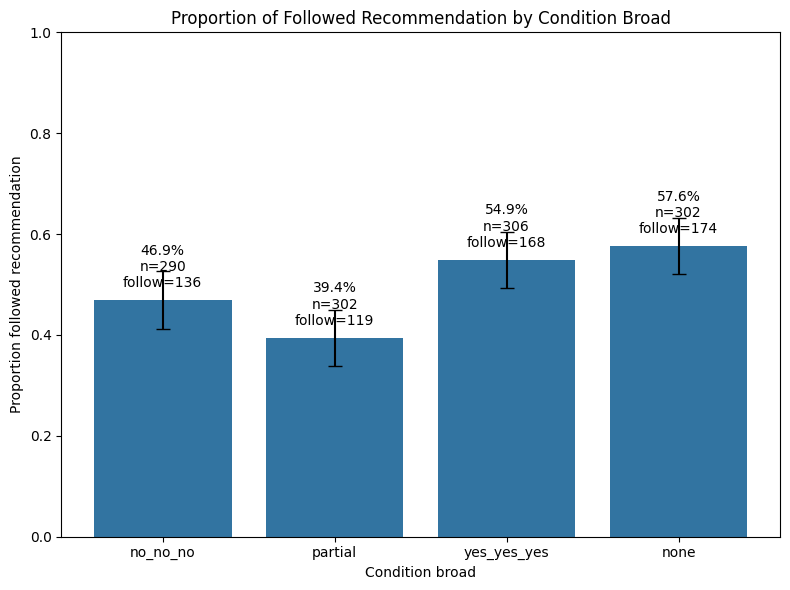

In [62]:
import seaborn as sns

order = ['no_no_no', 'partial', 'yes_yes_yes', 'none']
z = 1.96

summary = (
    df_clean.groupby('condition_broad', as_index=False)['followed_recommendation']
    .agg(proportion='mean', count='size', follow_count='sum')
)
summary['percentage'] = summary['proportion'] * 100
summary['ci_half_width'] = z * np.sqrt(summary['proportion'] * (1 - summary['proportion']) / summary['count'])
summary['ci_lower'] = summary['proportion'] - summary['ci_half_width']
summary['ci_upper'] = summary['proportion'] + summary['ci_half_width']
summary['condition_broad'] = pd.Categorical(summary['condition_broad'], categories=order, ordered=True)
summary.sort_values('condition_broad', inplace=True)
summary.reset_index(drop=True, inplace=True)

fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(
    data=summary,
    x='condition_broad',
    y='proportion',
    order=order,
    ci=None,
    ax=ax
)

ax.errorbar(
    x=np.arange(len(summary)),
    y=summary['proportion'],
    yerr=summary['ci_half_width'],
    fmt='none',
    ecolor='black',
    capsize=5,
    linewidth=1.5
)

ax.set_ylim(0, 1)
ax.set_xlabel('Condition broad')
ax.set_ylabel('Proportion followed recommendation')
ax.set_title('Proportion of Followed Recommendation by Condition Broad')

for bar, row in zip(ax.patches, summary.itertuples()):
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.02,
        f"{row.percentage:.1f}%\nn={row.count}\nfollow={row.follow_count}",
        ha='center',
        va='bottom'
    )

plt.tight_layout()


/var/folders/rd/m1nrl85s3hz1gbf4w5qd1pjc0000gn/T/ipykernel_55484/2463581289.py:55: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/var/folders/rd/m1nrl85s3hz1gbf4w5qd1pjc0000gn/T/ipykernel_55484/2463581289.py:55: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/var/folders/rd/m1nrl85s3hz1gbf4w5qd1pjc0000gn/T/ipykernel_55484/2463581289.py:55: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/var/folders/rd/m1nrl85s3hz1gbf4w5qd1pjc0000gn/T/ipykernel_55484/2463581289.py:55: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/var/folders/rd/m1nrl85s3hz1gbf4w5qd1pjc0000gn/T/ipykernel_55484/2463581289.py:55: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/var/folders/rd/m1nrl85s3hz1gbf4w5qd1pjc0000g

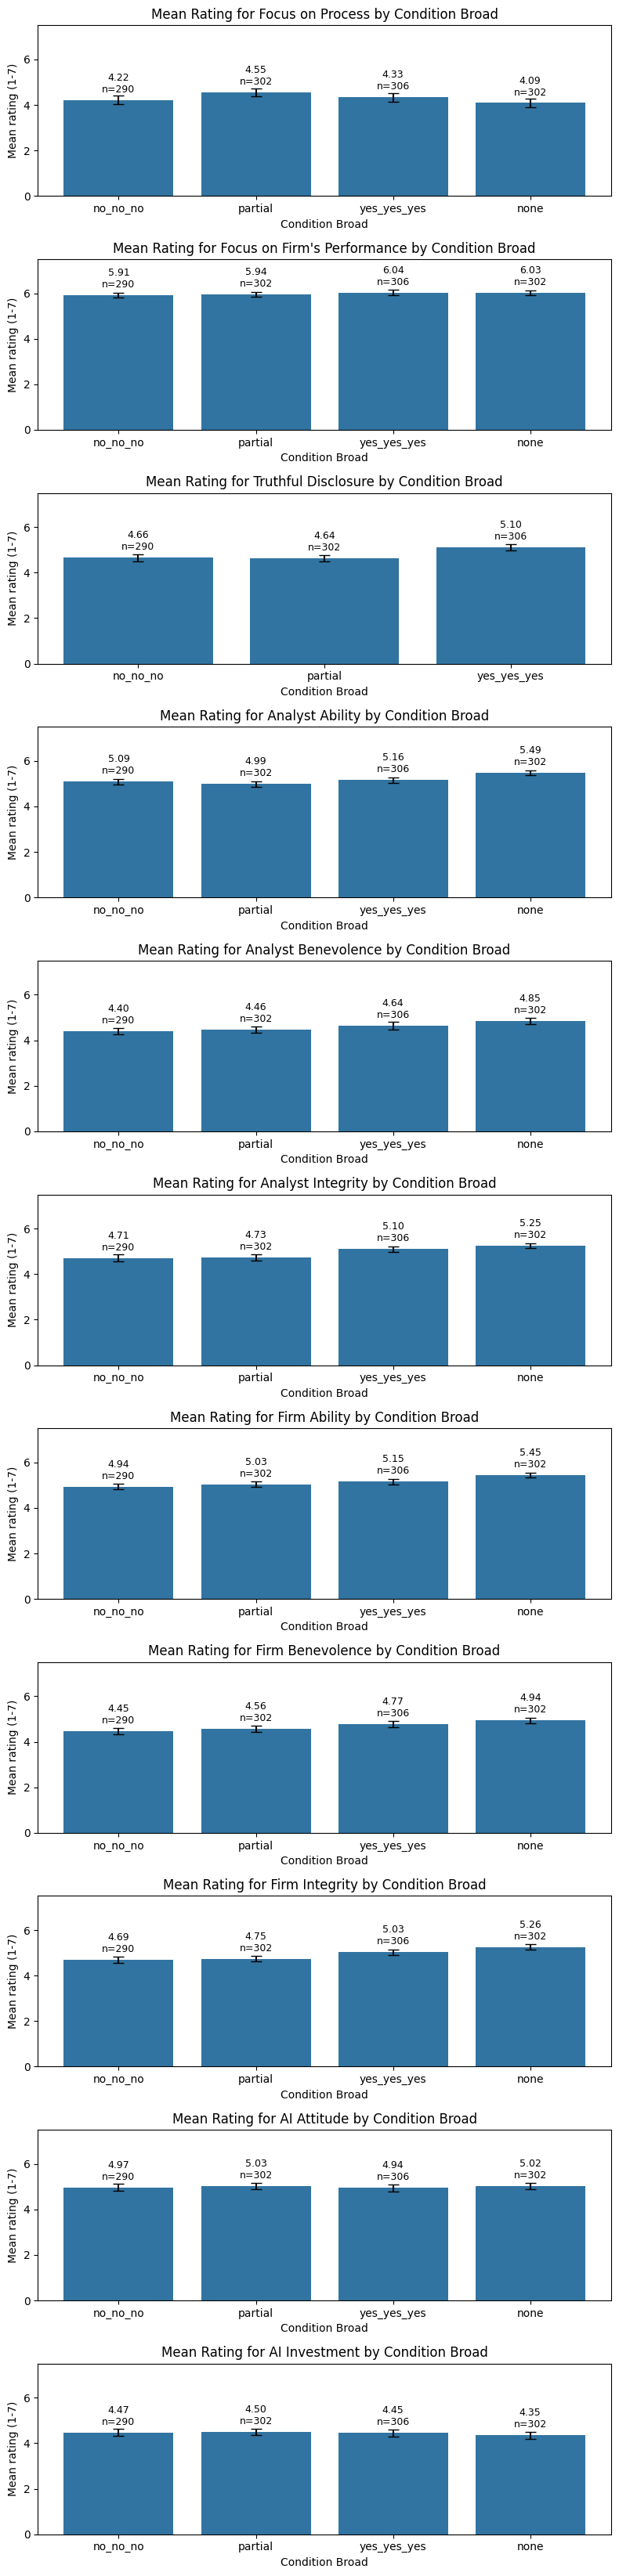

In [67]:
def display_outcome_plots(df, outcomes, group_col='condition_broad', order=None, ylabel='Mean rating', figsize_factor=0.5):
    """
    Generates and displays bar plots for a list of outcome variables.

    Args:
        df (pd.DataFrame): The input dataframe.
        outcomes (list of tuples): A list of (variable_name, plot_title) tuples.
        group_col (str): The column to group by.
        order (list): The order of categories for the x-axis.
        ylabel (str): The label for the y-axis.
        figsize_factor (float): Factor to adjust figure size.
    """
    z = 1.96
    
    num_outcomes = len(outcomes)
    fig, axes = plt.subplots(
        nrows=num_outcomes, 
        ncols=1, 
        figsize=(8, 5 * num_outcomes * figsize_factor),
        squeeze=False # Always return a 2D array for axes
    )
    axes = axes.flatten()

    for i, (outcome, label) in enumerate(outcomes):
        ax = axes[i]
        
        # Special handling for truthful_disclosure, which has no data for 'none' condition
        if outcome == 'truthful_disclosure':
            plot_df = df[df['condition_broad'] != 'none'].copy()
            current_order = [o for o in order if o != 'none'] if order else None
        else:
            plot_df = df.copy()
            current_order = order

        # Aggregate data
        summary_df = (
            plot_df.groupby(group_col)[outcome]
            .agg(mean='mean', std='std', count='size')
            .reset_index()
        )
        
        # Ensure types for calculation
        summary_df['mean'] = pd.to_numeric(summary_df['mean'], errors='coerce')
        summary_df['std'] = pd.to_numeric(summary_df['std'], errors='coerce')

        # Calculate confidence interval
        summary_df['ci_half_width'] = z * summary_df['std'] / np.sqrt(summary_df['count'])
        
        # Set categorical order for plotting
        if current_order:
            summary_df[group_col] = pd.Categorical(summary_df[group_col], categories=current_order, ordered=True)
            summary_df = summary_df.sort_values(group_col).reset_index(drop=True)

        # Plotting
        sns.barplot(
            data=summary_df,
            x=group_col,
            y='mean',
            order=current_order,
            ci=None,
            ax=ax,
            color=sns.color_palette()[0]
        )

        # Add error bars
        ax.errorbar(
            x=np.arange(len(summary_df)),
            y=summary_df['mean'].fillna(0),
            yerr=summary_df['ci_half_width'].fillna(0),
            fmt='none',
            ecolor='black',
            capsize=5,
            linewidth=1.5
        )

        # Annotations
        for bar, row in zip(ax.patches, summary_df.itertuples()):
            y_pos = bar.get_height()
            if pd.notna(y_pos):
                ax.annotate(
                    f"{y_pos:.2f}\nn={row.count}",
                    xy=(bar.get_x() + bar.get_width() / 2, y_pos),
                    xytext=(0, 5),
                    textcoords='offset points',
                    ha='center',
                    va='bottom',
                    fontsize=9
                )

        # Customization
        ax.set_ylim(0, 7.5)
        ax.set_title(f'Mean Rating for {label} by {group_col.replace("_", " ").title()}')
        ax.set_xlabel(group_col.replace("_", " ").title())
        ax.set_ylabel(ylabel)

    plt.tight_layout()
    plt.show()

# Define the outcome variables and their labels for the plots
outcomes = [
    ('process', 'Focus on Process'),
    ('performance', 'Focus on Firm\'s Performance'),
    ('truthful_disclosure', 'Truthful Disclosure'),
    ('analyst_ability', 'Analyst Ability'),
    ('analyst_benevolence', 'Analyst Benevolence'),
    ('analyst_integrity', 'Analyst Integrity'),
    ('firm_ability', 'Firm Ability'),
    ('firm_benevolence', 'Firm Benevolence'),
    ('firm_integrity', 'Firm Integrity'),
    ('ai_attitude', 'AI Attitude'),
    ('ai_investment', 'AI Investment')
]

# Define the order for the x-axis categories
condition_broad_order = ['no_no_no', 'partial', 'yes_yes_yes', 'none']

# Generate and display the plots
display_outcome_plots(
    df_clean,
    outcomes,
    group_col='condition_broad',
    order=condition_broad_order,
    ylabel='Mean rating (1-7)',
    figsize_factor=0.6
)


/var/folders/rd/m1nrl85s3hz1gbf4w5qd1pjc0000gn/T/ipykernel_55484/924391216.py:36: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=summary, x=group_col, y='value', order=categories, ci=None, ax=ax)


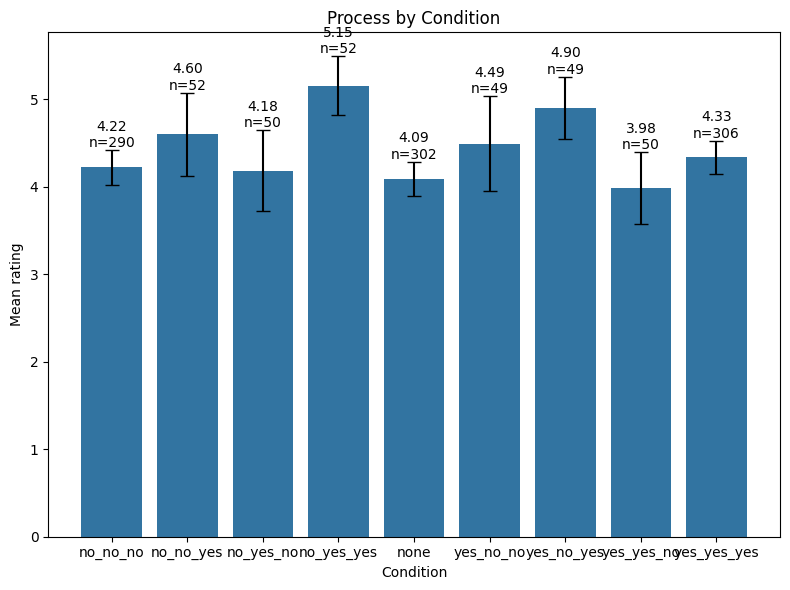

/var/folders/rd/m1nrl85s3hz1gbf4w5qd1pjc0000gn/T/ipykernel_55484/924391216.py:36: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=summary, x=group_col, y='value', order=categories, ci=None, ax=ax)


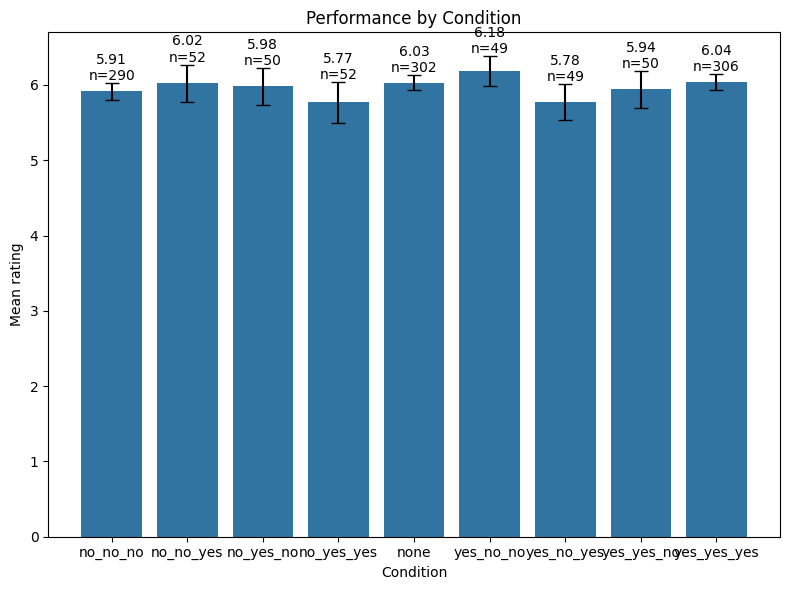

/var/folders/rd/m1nrl85s3hz1gbf4w5qd1pjc0000gn/T/ipykernel_55484/924391216.py:36: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=summary, x=group_col, y='value', order=categories, ci=None, ax=ax)


TypeError: float() argument must be a string or a real number, not 'NAType'

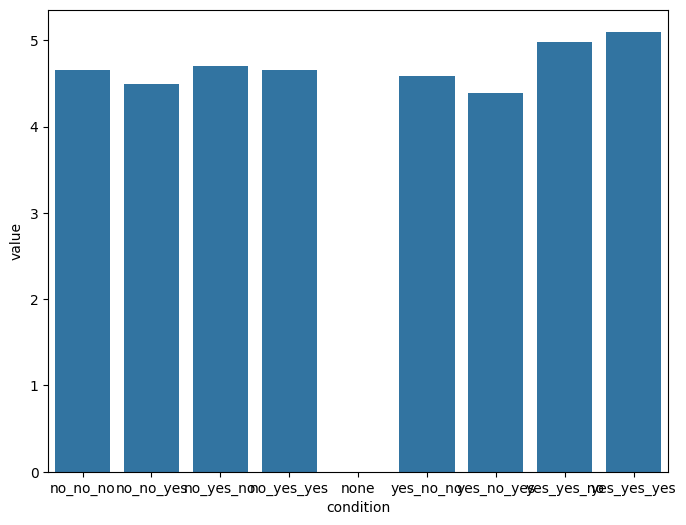

In [64]:
display_outcome_plots(
    df_clean,
    outcomes,
    group_col='condition',
    order=condition_order,
    ylabel='Mean rating',
    figsize_factor=0.6
)